# 教程7: STER cell下游分析

取这个标题不是标题党，是因为我们关注到STER是一类新的细胞类型，同时它的marker基因SOX11很有意思，基序都在视神经上。

在前文的分析我们已经发现了，4个月的视网膜母细胞瘤还有Photoreceptor细胞，2年的就没有了，虽然我们后来通过公共数据库（还没放进教程）发现，2年-6年的视网膜母细胞瘤也有Photoreceptor细胞，进一步地我们发现，这个2年的细胞发生了视神经入侵（癌细胞转移）所以我们可以认为，这个数据可以揭示癌细胞转移后的一些机理，如何抑制视网膜退化等。

回到正题，我们发现视神经被破坏了，而且这个破坏很有可能是STER cell调控的，所以我们就分析了一下STER cell的一些功能。

在分析之前，我们需要研究一下在两个组学层中，有哪些基因是同时保持染色质开放与基因表达的，或者只表达基因/不开放染色质，再看看STER cell中的这些基因是什么。

## 1. 调控基因分析

在GLUE的分析结果中，我们得到了基因与染色质调控之间的关系，这些参与调控的基因可能也STER细胞相关，所以我们先把这些基因筛选出来

In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import scglue
print('scglue(Ver): ',scglue.__version__)

#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D
5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4


Global seed set to 0


scvi(Ver):  0.20.1
scglue(Ver):  0.3.2


### 1.1 调控网络图构建 

这个的构建是很有意思的，我们使用GLUE的结果来构建，利用varm里面的'X_glue'计算gene与feature的余弦相似度，然后找到相关性最高的feature，认为其构成顺式调控元件

In [4]:
import networkx as nx
guidance_hvf = nx.read_graphml(current_path+"data/scglue/guidance-hvf.graphml.gz")

In [17]:
adata_rna = sc.read(current_path+"data/scglue/rna-emb.h5ad")
adata_atac = sc.read(current_path+"data/scglue/atac-emb.h5ad")


In [18]:
adata_rna.var["name"] = adata_rna.var_names
adata_atac.var["name"] = adata_atac.var_names
genes = adata_rna.var.query("highly_variable").index
peaks = adata_atac.var.query("highly_variable").index
len(genes),len(peaks)

(3134, 113107)

In [19]:
features = pd.Index(np.concatenate([adata_rna.var_names, adata_atac.var_names]))
feature_embeddings = np.concatenate([adata_rna.varm["X_glue"], adata_atac.varm["X_glue"]])
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference: 100%|██████████| 154376/154376 [00:01<00:00, 77570.57it/s]


### 1.2 调控元件提取
这里就不是GLUE官方教程给的了，我们利用networkx的图的特征，从edges中提取出我们需要的score与qval

In [20]:
gene_rna=[i[0] for i in reginf.edges]
gene_atac=[i[1] for i in reginf.edges]
gene_score=[]
gene_qval=[]
gene_dict=dict(reginf.edges)
for r,a in zip(gene_rna,gene_atac):
    gene_score.append(gene_dict[(r,a)]['score'])
    gene_qval.append(gene_dict[(r,a)]['qval'])
gene2peak_pd=pd.DataFrame()
gene2peak_pd['rna']=gene_rna
gene2peak_pd['atac']=gene_atac
gene2peak_pd['score']=gene_score
gene2peak_pd['qval']=gene_qval
gene2peak_pd.head()

,rna,atac,score,qval
0,UPP2,chr2_158303524_158304381,-0.177337,0.999987
1,UPP2,chr2_158306541_158307558,-0.126076,0.999987
2,UPP2,chr2_158313994_158314905,-0.214355,0.999987
3,UPP2,chr2_158329047_158329966,-0.270667,0.999987
4,UPP2,chr2_158346772_158347602,-0.193346,0.999987


In [245]:
gene2peak_pd['plot_qval']=(1-abs(gene2peak_pd['score']))+gene2peak_pd['qval']

In [239]:
gene2peak_pd.loc[gene2peak_pd['qval']<0.1].sort_values('qval').drop_duplicates('rna')

,rna,atac,score,qval
72390,IL3RA,chrX_1218468_1219351,0.995240,0.000000
28523,IFI44L,chr1_78457750_78458664,0.994992,0.000000
137870,LUM,chr12_91088586_91089508,0.997150,0.000000
137480,HBB,chr11_5286804_5287801,0.997643,0.000000
132484,TYRP1,chr9_12711229_12712251,0.995105,0.000000
...,...,...,...,...
102186,GMNN,chr6_24645907_24646844,0.987924,0.097778
55234,S100A10,chr1_151120159_151121041,0.988252,0.097778
105878,UGDH,chr4_39491727_39492945,0.988257,0.097778
15887,CENPE,chr4_106477727_106478634,0.987853,0.097778


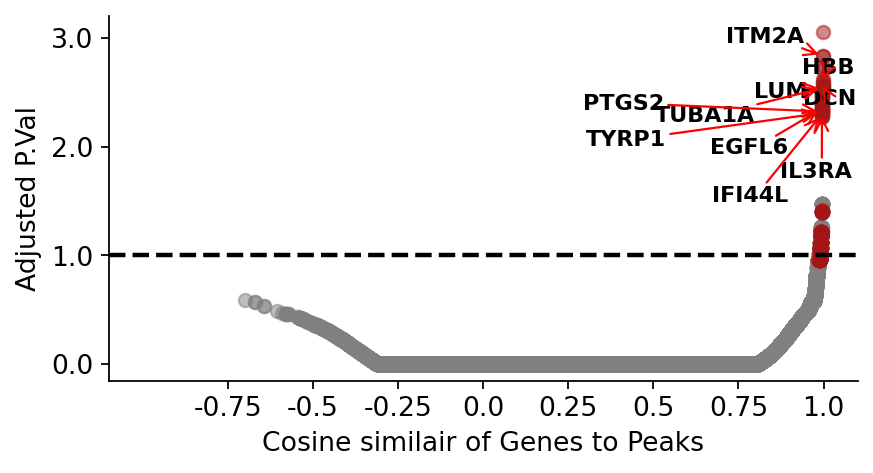

In [247]:
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(gene2peak_pd['score'],-np.log10(gene2peak_pd['qval']),color='grey',#颜色
            alpha=.5)
ax.scatter(gene2peak_pd.loc[gene2peak_pd['qval']<0.1,'score'],
            -np.log10(gene2peak_pd.loc[gene2peak_pd['qval']<0.1,'plot_qval']),color='#a51616',#选择色卡第15个颜色
           alpha=.5,#透明度
           )

from adjustText import adjust_text

hub_gene=gene2peak_pd.loc[gene2peak_pd['qval']<0.1].sort_values('qval').drop_duplicates('rna').index
texts=[ax.text(gene2peak_pd.loc[i,'score'], 
               -np.log10(gene2peak_pd.loc[i,'plot_qval']),
               gene2peak_pd.loc[i,'rna'],
               fontdict={'size':10,'weight':'bold'}
               ) for i in hub_gene[:10]]
adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.set_xticks(ax.get_xticks()[1:-1],#获取x坐标轴内容
              [round(i,2) for i in ax.get_xticks()[1:-1]],#更新x坐标轴内容
              fontsize=12,
              )


ax.set_yticks(ax.get_yticks()[1:-1],#获取x坐标轴内容
              [round(i,2) for i in ax.get_yticks()[1:-1]],#更新x坐标轴内容
              fontsize=12,
              )

ax.plot([-1.1,1.1],
        [1,1],
        linewidth=2, 
        linestyle="--",
        color='black')

plt.grid(False)

ax.set_ylabel('Adjusted P.Val',fontsize=12)
ax.set_xlabel('Cosine similair of Genes to Peaks',fontsize=12)

plt.xlim(-1.1,1.1)
plt.savefig(current_path+'result/analysis2/prop_cor_genes.png',dpi=300,bbox_inches='tight')

In [22]:
gene2peak_pd.to_csv(current_path+'data/analysis2/gene2peak.csv')

### 1.3 细胞调控基因分析

我们可以选择每个细胞的前50个差异基因作为这个细胞的marker，然后将这些marker与上面分析找到的差异表达调控基因取交集，即可找到细胞特异性的调控基因

In [23]:
rna=sc.read(current_path+'data/analysis1/rna_anno.h5ad')
atac=sc.read(current_path+'data/analysis1/atac_anno.h5ad')

In [27]:
#读取基因调控peaks图
gene2peak_pd=pd.read_csv(current_path+'data/analysis2/gene2peak.csv',index_col=0)

In [24]:
#对每个major_celltype的marker基因进行排序
rna.uns['log1p']['base']=None
sc.tl.rank_genes_groups(rna, 'major_celltype', method='t-test',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


In [25]:
#这是一个很有意思的代码，目的是筛选出前面排序好的marker基因
target_dict_all={}
for ad,name in zip([rna],['RNA']):
    #读取细胞类型
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    #细胞类型字典，字典的值就是marker基因
    target_dict={}
    target_pd=pd.DataFrame()
    #读取排序前50的基因
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(50):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker
    target_dict_all[name]=target_dict

In [30]:
#查看qval小于0.1的基因以及对应的顺式调控单元
gene2peak_pd.loc[gene2peak_pd['qval']<0.1]['rna']

,rna,atac,score,qval
89,KRT5,chr12_52471281_52472377,0.991109,0.076336
91,KRT5,chr12_52490141_52491005,0.994032,0.033898
2190,HLA-C,chr6_31212669_31213535,0.990620,0.076433
2536,ANP32E,chr1_149359169_149360085,0.988712,0.096154
2537,ANP32E,chr1_149360607_149361544,0.988764,0.096154
...,...,...,...,...
153930,DEPP1,chr10_45862311_45863052,0.988966,0.096154
154332,TFF1,chr21_40750473_40751335,0.993451,0.054795
154333,TFF1,chr21_40751737_40752355,0.992189,0.058252
154334,TFF1,chr21_40753571_40754420,0.991730,0.067797


In [31]:
#将上面的顺式调控单元与细胞特异性marker取交集
ret_target_dict={}
celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
for i in range(len(celltype)):
    ret_target_dict[celltype[i][0]]=list(set(target_dict_all['RNA'][celltype[i][0]]) &  set(gene2peak_pd.loc[gene2peak_pd['qval']<0.1]['rna'].values))
ret_target_dict

{'Astrocytes': ['ITM2B',
  'S100A11',
  'TACSTD2',
  'DSG3',
  'ALDH3A1',
  'CLDN1',
  'ANXA1',
  'S100A6',
  'ADIRF',
  'S100A10',
  'KRT12',
  'KRT5'],
 'Lymphocytes': ['TTR',
  'HLA-B',
  'TYRP1',
  'HLA-C',
  'TOMM7',
  'VIM',
  'HLA-E',
  'SP100'],
 'Müller glia cells': ['LGALS1',
  'DCN',
  'IFITM3',
  'MGP',
  'LUM',
  'COL1A1',
  'SOCS3',
  'ITM2A',
  'VIM',
  'EGR1',
  'COL3A1'],
 'P-Photoreceptor cells': ['HMGB2'],
 'Photoreceptor cells': [],
 'RPE cells': ['TTR',
  'PLAAT4',
  'ITM2B',
  'HLA-B',
  'IFITM3',
  'TYRP1',
  'FRZB',
  'HLA-C',
  'GLUL',
  'CST3',
  'RNASE1'],
 'Retinal stem cells': ['TUBA1A', 'VIM'],
 'STER cells': ['TFF1', 'TUBB2B', 'SSTR2', 'GMNN', 'SOX4']}

我们发现STER cells的调控基因是['TFF1', 'TUBB2B', 'SSTR2', 'GMNN', 'SOX4']，我们看一下哪个最显著

In [35]:
gene2peak_pd.loc[(gene2peak_pd['rna'].isin(ret_target_dict['STER cells'])&(gene2peak_pd['qval']<0.1))]

,rna,atac,score,qval
85608,TUBB2B,chr6_3095276_3095697,0.992928,0.058252
85609,TUBB2B,chr6_3095730_3096650,0.989869,0.085890
102186,GMNN,chr6_24645907_24646844,0.987924,0.097778
111951,SOX4,chr6_21465917_21466828,0.994210,0.033898
111952,SOX4,chr6_21467400_21468365,0.992558,0.058252
111953,SOX4,chr6_21468976_21469923,0.993405,0.054795
124395,SSTR2,chr17_74054258_74055198,0.992409,0.058252
154332,TFF1,chr21_40750473_40751335,0.993451,0.054795
154333,TFF1,chr21_40751737_40752355,0.992189,0.058252
154334,TFF1,chr21_40753571_40754420,0.991730,0.067797


## 2. scATAC可视化

这个函数应该是全网独家的了，欢迎大家仔细学习，如何使用Python绘制scATAC的peak图

我们使用`scglue.genomics.read_gtf`读取基因的位置

In [39]:
t2tchm13_gtf=scglue.genomics.read_gtf(current_path+'gtf/chm13v2.0_RefSeq_Liftoff_v4.gtf.gz')
t2tchm13_gtf.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,chrX,Liftoff,gene,103469,105172,.,-,.,"gene_id ""LOC124905300_1""; ID ""LOC124905300_1"";..."
1,chrX,Liftoff,transcript,103469,105172,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
2,chrX,Liftoff,exon,103469,103996,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
3,chrX,Liftoff,exon,104237,104607,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
4,chrX,Liftoff,exon,104915,104952,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."


In [225]:
#读取特定基因的染色体结构
#exon代表外显子
#gene代表基因
#strand为+的时候代表正向，-的时候代表负向
goal_gene='SOX4'
goal_gtf=t2tchm13_gtf.loc[t2tchm13_gtf['attribute'].str.contains('gene_id "{}"'.format(goal_gene))]
goal_gtf1=goal_gtf.split_attribute()

In [226]:
goal_gtf1=pd.DataFrame(goal_gtf1)
goal_gtf1.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id,...,transcript_id,Parent,matches_ref_protein,product,tag,transcript_biotype,valid_ORF,exon_number,protein_id,original_biotype
1651103,chr6,Liftoff,gene,21466412,21471279,.,+,.,"gene_id ""SOX4""; ID ""SOX4""; copy_num_ID ""SOX4_0...",SOX4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651104,chr6,Liftoff,transcript,21466412,21471279,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,SOX4,True,SRY-box transcription factor 4,MANE Select,mRNA,True,NaN,NaN,NaN
1651105,chr6,Liftoff,exon,21466412,21471279,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,SRY-box transcription factor 4,MANE Select,mRNA,NaN,1,NaN,NaN
1651106,chr6,Liftoff,CDS,21467196,21468620,.,+,0,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,transcription factor SOX-4,MANE Select,NaN,NaN,1,NP_003098.1,NaN
1651107,chr6,Liftoff,five_prime_utr,21466412,21467195,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,SRY-box transcription factor 4,MANE Select,mRNA,NaN,1,NaN,five_prime_UTR


Astrocytes chr6 21456412 21476412
Lymphocytes chr6 21456412 21476412
Müller glia cells chr6 21456412 21476412
P-Photoreceptor cells chr6 21456412 21476412
Photoreceptor cells chr6 21456412 21476412
RPE cells chr6 21456412 21476412
Retinal stem cells chr6 21456412 21476412
STER cells chr6 21456412 21476412
chr6 21456412 21476412


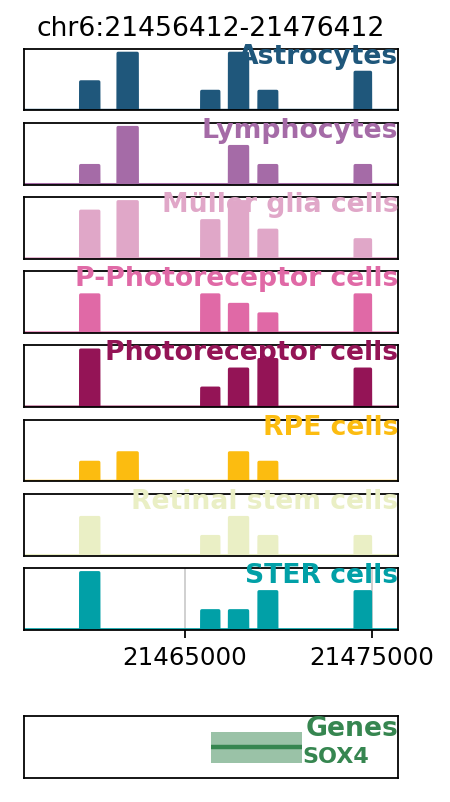

In [227]:
#绘制特定基因在不同细胞类型中的scATAC情况
g=goal_gtf1.loc[goal_gtf1['feature']=='gene'].iloc[0]
#tss代表启动子
if g.strand!='-':
    tss=g.start
else:
    tss=g.end
#绘制启动子前后10,000bp的区域
plot_chr='{}:{}-{}'.format(g.seqname,tss-10000,tss+10000)
#绘图
fig, axes = plt.subplots(10,1,figsize=(3,6))
#celltype代表细胞类型，num代表当前axes，color代表细胞类型的颜色
for celltype,num,color in zip(atac.obs['major_celltype'].cat.categories,range(8),atac.uns['major_celltype_colors']):
    #细胞类型
    plot_celltype=celltype
    #绘制的染色体
    plot_chrom=plot_chr.split(':')[0]
    #绘制的染色体起点
    plot_start=int(plot_chr.split(':')[1].split('-')[0])
    #绘制的终点
    plot_end=int(plot_chr.split(':')[1].split('-')[1])
    #绘制的数据，index为染色体起点-终点的每一个值，Value代表染色体的开放程度
    plot_data=pd.DataFrame(np.zeros(plot_end-plot_start),index=range(plot_start,plot_end),columns=['Value'])
    print(celltype,plot_chrom,plot_start,plot_end)
    #选取在启动子前后10,000bp的区域内的ATAC位置
    for i in atac.var.loc[((atac.var['chrom']==plot_chrom) & (atac.var['chromStart']>plot_start)&(atac.var['chromEnd']<plot_end))].index:
        #print(i)
        #ATAC起点
        chrom_start=int(i.split('_')[1])
        #ATAC终点
        chrom_end=int(i.split('_')[2])
        #print(chrom_start,chrom_end)
        #有效表达的细胞数量
        cell_valid_len=len((atac[:,i].X[atac[:,i].X!=0]))
       
        if atac[atac.obs['major_celltype']==plot_celltype,i].X.sum()==0:
            #如果特定细胞中有效表达的细胞数量为0，那么全部为0
            region_cell_valid_len=0
            region_max=0
        else:
            #如果特定细胞中有效表达的细胞数不为0，那么染色体开放区域定义为该（区域内最大值*区域内有效细胞数量/全部有效细胞数量）
            yk=atac[atac.obs['major_celltype']==plot_celltype,i].X[atac[atac.obs['major_celltype']==plot_celltype,i].X!=0]
            #区域内有效细胞数量
            region_cell_valid_len=len(yk)
            #区域内最大值
            region_max=yk.max()

        #plot_data.loc[range(chrom_start,chrom_end),'Value']+=atac[atac.obs['major_celltype']==plot_celltype,i].X.toarray().reshape(-1).mean()
        plot_data.loc[range(chrom_start,chrom_end),'Value']+=region_cell_valid_len/cell_valid_len*region_max
    
    #绘图
    axes[num].plot(plot_data.index,plot_data.Value,c=color)
    axes[num].fill_between(plot_data.index,0,plot_data.Value,facecolor = color,alpha = 1)
    axes[num].set_xlim(plot_start,plot_end)
    #定义要画横坐标的位置，画在1/4处
    inter=(plot_end-plot_start)//4
    
    axes[num].set_yticks([])
    if num!=7:
        axes[num].set_xticks([])
    else:
        inter=(plot_end-plot_start)//4
        end_inter=plot_end-plot_end%inter
        start_inter=plot_end-plot_end%(inter)-inter*2
        axes[num].set_xticks([start_inter,end_inter])
    #plot_data

#重新设置所有细胞类型的染色质开放区域的最大值，以及细胞注释的位置
for celltype,num,color in zip(atac.obs['major_celltype'].cat.categories,range(8),atac.uns['major_celltype_colors']):
    axes[num].set_ylim(0,plot_data['Value'].max()+0.5)
    axes[num].text(plot_end,plot_data['Value'].max()-1,celltype,color=color,fontweight='bold',
                   fontsize=12,horizontalalignment = "right")
    
axes[7].get_xaxis().get_major_formatter().set_scientific(False)
axes[7].set_xticklabels([start_inter,end_inter],fontsize=11)
axes[8].set_visible(False)

#第二部分，绘制基因结构，exon用矩形来画

from matplotlib.patches import Rectangle
#fig, ax = plt.subplots(figsize=(4,1))
print(plot_chrom,plot_start,plot_end)

plt.hlines(y=1,xmin=g.start, xmax=g.end, color=sc_color[1], linewidth=2)


for i in range(len(goal_gtf1.loc[goal_gtf1['feature']=='exon'])):
    exon=goal_gtf1.loc[goal_gtf1['feature']=='exon'].iloc[i]
    #print(exon.start,exon.end)
    rect = plt.Rectangle((exon.start,0.5),exon.end-exon.start,1,facecolor=sc_color[1],alpha=0.5)
    axes[9].add_patch(rect)
axes[9].text(plot_end,1.4,'Genes',color=sc_color[1],fontweight='bold',
                   fontsize=12,horizontalalignment = "right")
axes[0].set_title(plot_chr,fontsize=12)

plt.xlim(plot_start,plot_end)
plt.ylim(0,2)
plt.text(g.end,0.5,goal_gene,fontsize=10,color=sc_color[1],fontweight='bold')
plt.xticks([])
plt.yticks([])

plt.savefig(current_path+'result/analysis2/{}_atac.png'.format(goal_gene),dpi=300,bbox_inches='tight')

## 3. 富集分析

这里我们使用离线的方式进行富集分析，通路数据库从[enrichr](https://maayanlab.cloud/Enrichr/#libraries)中下载

- 细胞组成（cellular component，CC）: 一般用来描述基因产物的发挥作用的位置，比如一个蛋白可能定位在细胞核中，也可能定位在核糖体中；
- 生物过程（biological process，BP）: 描述的是指基因产物所联系的一个大的生物功能，或者说是它们要完成的一个大的生物目标，例如有丝分裂或嘌呤代谢；
- 分子功能（Molecular Function，MF）: 主要是指基因产物分子所执行的任务，例如一个蛋白质可能一个转录因子或是一个载体蛋白。

在一个GO注释中，例如，一个基因的产物是细胞色素c（cytochrome c），那么这个基因的产物就会被一个分子功能术语（Molecular Function）描述为氧化还原酶活性（oxidoreductase activity ），被生物过程（Biological Process）描述为氧化磷酸化（oxidative phosphorylation），被细胞成分（Cellular Component ）描述为线性体基质（mitochondrial matrix）和线粒体内膜（mitochondrial inner membrane）。


### 3.1 GO_Biological_Process


In [ ]:
#读取通路数据库
go_bio_geneset=pd.read_csv(current_path+'geneset/GO_Biological_Process_2021.txt',sep='\t\t',header=None)
go_bio_geneset.head()

In [252]:
go_bio_dict={}
for i in go_bio_geneset.index:
    go_bio_dict[go_bio_geneset.loc[i,0]]=go_bio_geneset.loc[i,1].split('\t')

In [253]:
import gseapy as gp
enr = gp.enrichr(gene_list=[i.upper() for i in target_dict['STER cells']],
				 gene_sets=go_bio_dict,
				 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='STER',
				 outdir=current_path+'result/analysis2/STER',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140068529206272,"CD4-positive, alpha-beta T cell activation (GO...",1/5,0.013062,0.111355,104.884298,HMGB1
1,CUSTOM140068529206272,"DNA catabolic process, endonucleolytic (GO:000...",1/22,0.056235,0.139463,25.615488,HMGB1
2,CUSTOM140068529206272,DNA conformation change (GO:0071103),1/18,0.046246,0.133080,31.160524,HMGB1
3,CUSTOM140068529206272,"DNA damage response, signal transduction by p5...",1/74,0.177122,0.230970,7.715070,SOX4
4,CUSTOM140068529206272,"DNA damage response, signal transduction by p5...",1/56,0.137101,0.201950,10.182623,SOX4


In [256]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.05]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Odds Ratio'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]
kegg_result_ad['fraction']=[int(i.split('/')[0])/int(i.split('/')[1]) for i in kegg_result_ad['Overlap']]

In [257]:
def plot_text_set(text):
    if len(text)>20:
        ty=text.split(' ')
        ty_len=len(ty)
        ty_mid=ty_len//2
        res=''
        for i in range(ty_len):
            if i!=ty_mid:
                res+=ty[i]+' '
            else:
                res+='\n'+ty[i]+' '
        return res
    else:
        return text

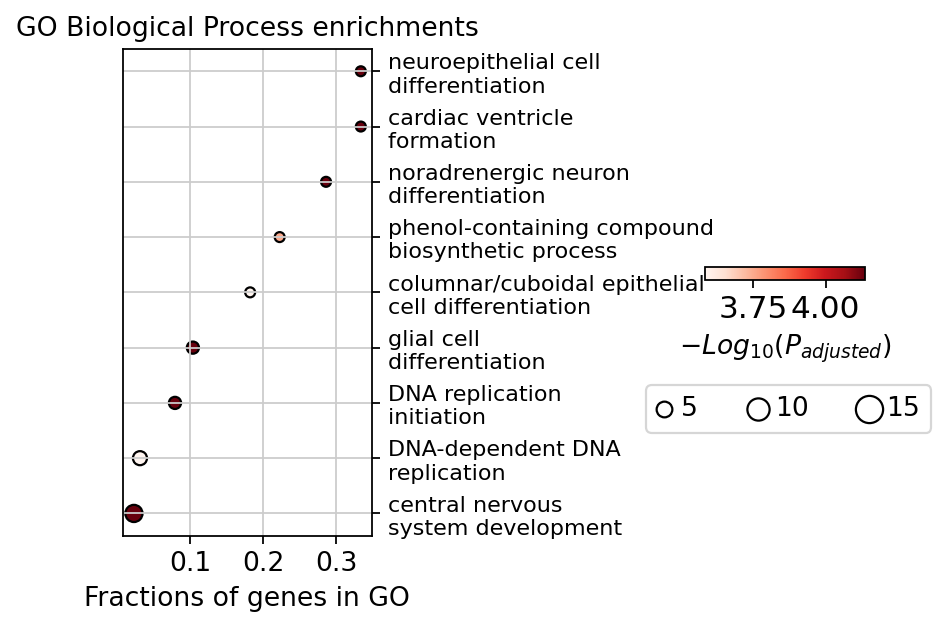

In [259]:

pp=plt.figure(figsize=(2,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
plot_data2=kegg_result_ad.sort_values('Adjusted P-value')[:9].sort_values('logc')
b=plt.scatter(plot_data2['fraction'],range(len(plot_data2['logc'])),
           s=plot_data2['num']*10,linewidths=1,edgecolors='black',c=plot_data2['logp'],cmap='Reds')
ax.yaxis.tick_right()
plt.yticks(range(len(plot_data2['fraction'])),[plot_text_set(i.split('(')[0]) for i in plot_data2['Term']],
          fontsize=10,)
plt.xticks(fontsize=12,)
plt.title('GO Biological Process enrichments',fontsize=12)
plt.xlabel('Fractions of genes in GO',fontsize=12)


fig = plt.gcf()
cax = fig.add_axes([2, 0.55, 0.5, 0.02])
#im = cax.imshow(plot_data2['logp'], cmap=gocmap)
cb=plt.colorbar(shrink=0.25,cax=cax,orientation='horizontal')
cb.set_label(r'$-Log_{10}(P_{adjusted})$',fontdict={'size':12})

gll = plt.scatter([],[], s=5*10, marker='o', color='white',edgecolors='black')
gl = plt.scatter([],[], s=10*10, marker='o', color='white',edgecolors='black')
ga = plt.scatter([],[], s=15*10, marker='o', color='white',edgecolors='black')

plt.legend((gll,gl,ga),
       ('5', '10', '15'),
       loc='lower left',
       ncol=3,bbox_to_anchor=(-0.45, -13),
       fontsize=12)
#plt.text(15,-15,'Count')
plt.savefig("result/analysis2/STER_go_bio.png",dpi=300,bbox_inches = 'tight')

### 3.2 GO_Molecular_Function

GO富集分析我只做了MF和BP，因为CC是位置分析，与我们需要讲的故事关系不大所以不做

In [261]:
go_bio_geneset=pd.read_csv(current_path+'geneset/GO_Molecular_Function_2021.txt',sep='\t\t',header=None)
go_bio_geneset.head()

,0,1
0,"1,4-alpha-oligoglucan phosphorylase activity (...",MTAP\tPYGB\tPYGL\tPYGM\tGDPGP1
1,1-acylglycerol-3-phosphate O-acyltransferase a...,ABHD5\tLPCAT2\tLPCAT1\tAGPAT1\tAGPAT2\tLCLAT1\...
2,1-acylglycerophosphocholine O-acyltransferase ...,PRDX6\tLPCAT4\tLPCAT3\tLPCAT2\tMBOAT2\tLPCAT1
3,1-alkyl-2-acetylglycerophosphocholine esterase...,PLA2G10\tLCAT\tPLA2G6\tPLA2G7\tPAFAH2\tPAFAH1B...
4,1-phosphatidylinositol binding (GO:0005545),EPB41\tZFYVE9\tFRMPD2\tSESTD1\tZFYVE1\tSNX10\t...


In [262]:
go_bio_dict={}
for i in go_bio_geneset.index:
    go_bio_dict[go_bio_geneset.loc[i,0]]=go_bio_geneset.loc[i,1].split('\t')

In [263]:
import gseapy as gp
enr = gp.enrichr(gene_list=[i.upper() for i in target_dict['STER cells']],
				 gene_sets=go_bio_dict,
				 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='STER_GO_MOL',
				 outdir=current_path+'result/analysis2/STER_GO_MOL',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140068605258880,ATP binding (GO:0005524),2/273,0.160827,0.215106,3.537289,HSP90AB1;SRPK1
1,CUSTOM140068605258880,C-X-C chemokine binding (GO:0019958),1/5,0.013062,0.088428,104.884298,HMGB1
2,CUSTOM140068605258880,DNA binding (GO:0003677),6/755,0.013727,0.088428,3.535489,ILF2;NFIB;HMGA1;MEIS2;MCM3;HMGB1
3,CUSTOM140068605258880,"DNA binding, bending (GO:0008301)",1/16,0.041213,0.108824,34.941230,HMGB1
4,CUSTOM140068605258880,DNA polymerase binding (GO:0070182),2/18,0.001007,0.072488,53.005015,HSP90AB1;HMGB1


In [267]:
kegg_result_ad=enr.res2d[enr.res2d['P-value']<0.01]
kegg_result_ad['logp']=-np.log(kegg_result_ad['P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Odds Ratio'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]
kegg_result_ad['fraction']=[int(i.split('/')[0])/int(i.split('/')[1]) for i in kegg_result_ad['Overlap']]

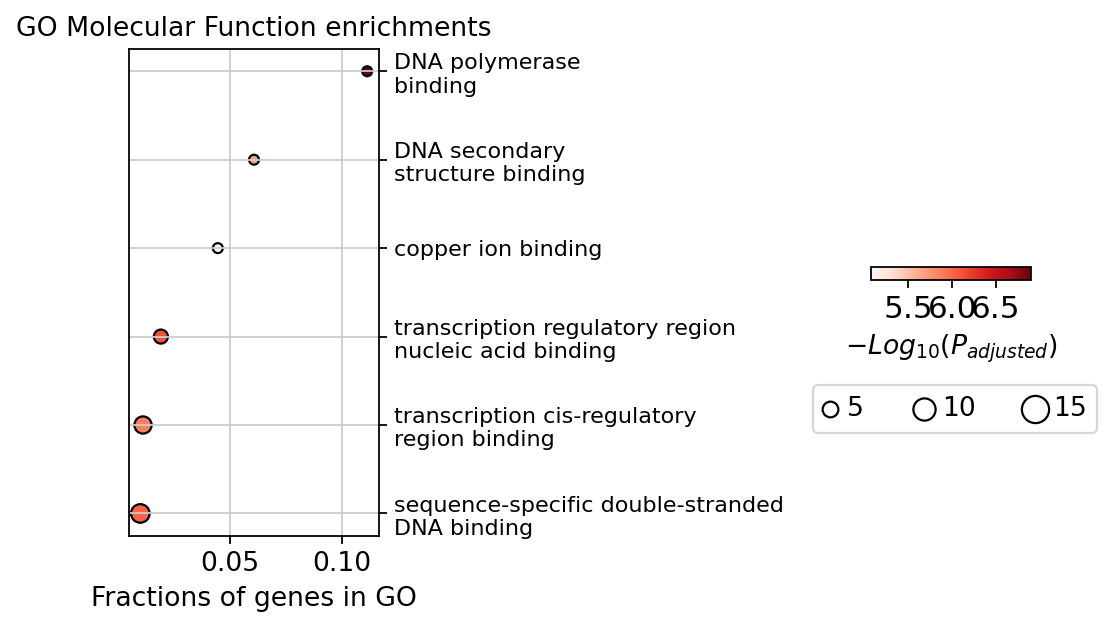

In [269]:

pp=plt.figure(figsize=(2,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
plot_data2=kegg_result_ad.sort_values('P-value')[:9].sort_values('logc')
b=plt.scatter(plot_data2['fraction'],range(len(plot_data2['logc'])),
           s=plot_data2['num']*10,linewidths=1,edgecolors='black',c=plot_data2['logp'],cmap='Reds')
ax.yaxis.tick_right()
plt.yticks(range(len(plot_data2['fraction'])),[plot_text_set(i.split('(')[0]) for i in plot_data2['Term']],
          fontsize=10,)
plt.xticks(fontsize=12,)
plt.title('GO Molecular Function enrichments',fontsize=12)
plt.xlabel('Fractions of genes in GO',fontsize=12)


fig = plt.gcf()
cax = fig.add_axes([2.5, 0.55, 0.5, 0.02])
#im = cax.imshow(plot_data2['logp'], cmap=gocmap)
cb=plt.colorbar(shrink=0.25,cax=cax,orientation='horizontal')
cb.set_label(r'$-Log_{10}(P_{adjusted})$',fontdict={'size':12})

gll = plt.scatter([],[], s=5*10, marker='o', color='white',edgecolors='black')
gl = plt.scatter([],[], s=10*10, marker='o', color='white',edgecolors='black')
ga = plt.scatter([],[], s=15*10, marker='o', color='white',edgecolors='black')

plt.legend((gll,gl,ga),
       ('5', '10', '15'),
       loc='lower left',
       ncol=3,bbox_to_anchor=(-0.45, -13),
       fontsize=12)
#plt.text(15,-15,'Count')
plt.savefig(current_path+"result/analysis2/STER_go_mol.png",dpi=300,bbox_inches = 'tight')

## 3.3 WikiPathway富集

一般常见的是KEGG富集分析，但是我觉得KEGG富集出来的通路没Wiki准，所以我个人用Wiki会多一点

In [270]:
go_bio_geneset=pd.read_csv(current_path+'geneset/WikiPathways_2019_Human.txt',sep='\t\t',header=None)
go_bio_geneset.head()

,0,1
0,"4-hydroxytamoxifen, Dexamethasone, and Retinoi...",MAP2K2\tMAP2K3\tMAP2K1\tEIF4EBP1\tTSC1\tMTOR\t...
1,ACE Inhibitor Pathway WP554,TGFB1\tACE\tNOS3\tATP6AP2\tCMA1\tNR3C2\tAGT\tK...
2,AGE/RAGE pathway WP2324,RHOA\tMMP7\tJUN\tMMP2\tMSN\tIRAK4\tMMP9\tMAPK1...
3,AMP-activated Protein Kinase (AMPK) Signaling ...,SLC2A4RG\tSTRADA\tSTRADB\tBORCS8-MEF2B\tTSC2\t...
4,ATM Signaling Network in Development and Disea...,G6PD\tATMIN\tH2AFX\tTSC2\tNFKB1\tMTOR\tRNF40\t...


In [271]:
go_bio_dict={}
for i in go_bio_geneset.index:
    go_bio_dict[go_bio_geneset.loc[i,0]]=go_bio_geneset.loc[i,1].split('\t')

In [272]:
import gseapy as gp
enr = gp.enrichr(gene_list=[i.upper() for i in target_dict['STER cells']],
				 gene_sets=go_bio_dict,
				 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='STER_WIKI',
				 outdir=current_path+'result/analysis2/STER_WIKI',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM140068604422976,Adipogenesis WP236,1/130,0.290349,0.375034,4.391385,HMGA1
1,CUSTOM140068604422976,Allograft Rejection WP2328,1/89,0.209079,0.330532,6.416963,HLA-DQB1
2,CUSTOM140068604422976,Alzheimers Disease WP2059,1/83,0.196445,0.330532,6.880240,GRIN2A
3,CUSTOM140068604422976,Amino Acid metabolism WP3925,2/91,0.023853,0.134444,10.675737,TPH1;ODC1
4,CUSTOM140068604422976,B Cell Receptor Signaling Pathway WP23,1/97,0.225621,0.341184,5.887956,ILF2


In [274]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.05]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Odds Ratio'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]
kegg_result_ad['fraction']=[int(i.split('/')[0])/int(i.split('/')[1]) for i in kegg_result_ad['Overlap']]

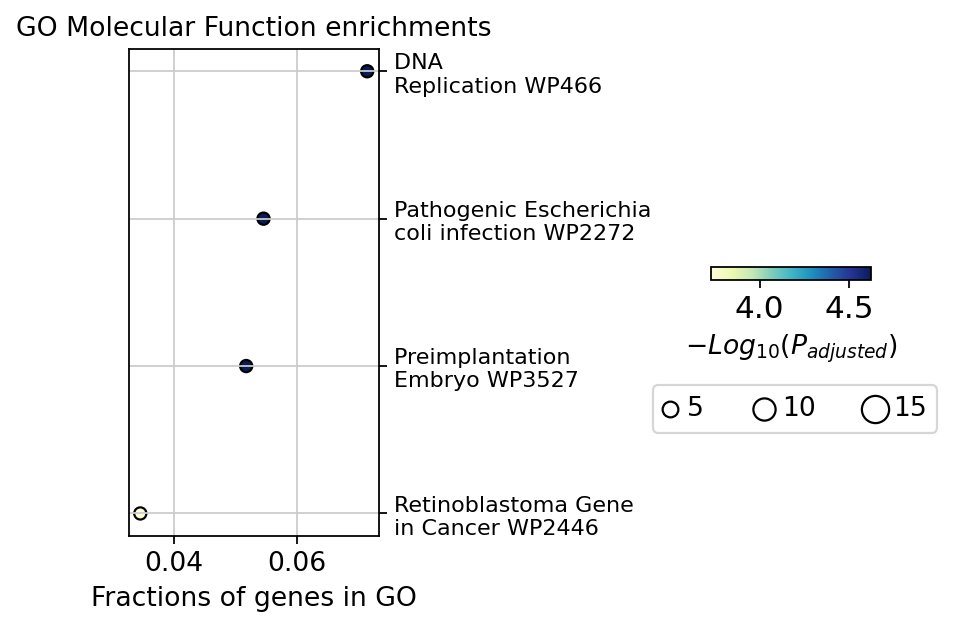

In [276]:

pp=plt.figure(figsize=(2,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
plot_data2=kegg_result_ad.sort_values('Adjusted P-value')[:9].sort_values('logc')
b=plt.scatter(plot_data2['fraction'],range(len(plot_data2['logc'])),
           s=plot_data2['num']*10,linewidths=1,edgecolors='black',c=plot_data2['logp'],cmap='YlGnBu')
ax.yaxis.tick_right()
plt.yticks(range(len(plot_data2['fraction'])),[plot_text_set(i.split('(')[0]) for i in plot_data2['Term']],
          fontsize=10,)
plt.xticks(fontsize=12,)
plt.title('GO Molecular Function enrichments',fontsize=12)
plt.xlabel('Fractions of genes in GO',fontsize=12)


fig = plt.gcf()
cax = fig.add_axes([2, 0.55, 0.5, 0.02])
#im = cax.imshow(plot_data2['logp'], cmap=gocmap)
cb=plt.colorbar(shrink=0.25,cax=cax,orientation='horizontal')
cb.set_label(r'$-Log_{10}(P_{adjusted})$',fontdict={'size':12})

gll = plt.scatter([],[], s=5*10, marker='o', color='white',edgecolors='black')
gl = plt.scatter([],[], s=10*10, marker='o', color='white',edgecolors='black')
ga = plt.scatter([],[], s=15*10, marker='o', color='white',edgecolors='black')

plt.legend((gll,gl,ga),
       ('5', '10', '15'),
       loc='lower left',
       ncol=3,bbox_to_anchor=(-0.45, -13),
       fontsize=12)
#plt.text(15,-15,'Count')
plt.savefig(current_path+"result/analysis2/STER_wiki.png",dpi=300,bbox_inches = 'tight')